# Importing Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    PolynomialFeatures, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    KBinsDiscretizer
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge, 
    Lasso,
    ElasticNet
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
)   
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    recall_score,
    precision_score
)

from sklearn.feature_selection import SelectFromModel

from scripts.clean_dataset import clean_dataset
from scripts.helper import currency, cal_accuracy
from scripts.model_serializer import ModelSerializer

# Importing the cleaned dataset

In [98]:
df_train = pd.read_csv('data/Train_cleaned.csv')
df_train = pd.read_csv('data/Train_cleaned_log_transformed.csv')
#df_test  = pd.read_csv('data/Test.csv')
#df_test  = clean_dataset(df_test)

In [99]:
df_train.shape

(3917, 30)

# Target and Features

In [113]:
# Target:
y = df_train['total_cost_euro_log']
# Features:
X = df_train.drop(['total_cost', 'total_cost_euro', 'total_cost_euro_log'], axis=1)
#X = df_train.drop(['total_cost', 'total_cost_euro'], axis=1)

## Seperate numerical and categorical features

In [114]:
num_features = list(X.select_dtypes(include=['number']).columns)
cat_features = list(X.select_dtypes(exclude=['number']).columns)

In [115]:
cat_features = list(set(cat_features) - set(['single_male', 'single_female', 'info_source', 'most_impressing', 'payment_mode']))
num_features = ['total_travelers', 'night_mainland', 'night_zanzibar']

In [116]:
#num_features = ['total_travelers', 'night_total', 'total_female']
#cat_features = ['country', 'age_group', 'travel_with', 'main_activity', 'tour_arrangement', 'purpose']

In [117]:
cat_features, num_features

(['first_trip_tz',
  'age_group',
  'package_transport_tz',
  'tour_arrangement',
  'package_insurance',
  'package_guided_tour',
  'travel_with',
  'package_accomodation',
  'package_transport_int',
  'country',
  'package_food',
  'package_sightseeing',
  'main_activity',
  'purpose'],
 ['total_travelers', 'night_mainland', 'night_zanzibar'])

# Splitting the dataset

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)#, stratify=y)#, random_state=47)

# Create a pipeline

## Building the pipeline

In [119]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
    ('poly',    PolynomialFeatures(degree=5))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

# Create a Logistic Regression pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestRegressor())),
#    ('classifier', Lasso()),
    ('classifier',   RandomForestRegressor(min_samples_leaf=5, max_depth=3)),
#    ('classifier',   RandomForestClassifier())
#    ('classifier', Ridge(alpha=0.1)),
#('classifier', DecisionTreeRegressor(max_depth=4, min_samples_leaf=1))


])


estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['total_travelers',
                                                   'night_mainland',
                                                   'night_zanzibar']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   On...
                                                   'package_transport_tz',
                                                   'tour_arrangement',
                                                   'package_insurance',
                                                   'package_guided_tour',
                                                   'travel_with',
                                                   'package_accomodation',
                                                   'package_transport_int',
                                                   'country', 'package_food',
                                                   'package_sightseeing',
                                                   'main_activity',
                                                   'purpose'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestRegressor())),
                ('classifier',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=5))])

## Predicting

In [133]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)



train_score  = estimator.score(X_train, y_train)
test_score   = estimator.score(X_test,  y_test)

print("Accuracy on train set:", round(train_score, 2))
print("Accuracy on test set:",  round(test_score, 2))

Accuracy on train set: 0.51
Accuracy on test set: 0.51


In [134]:
y_pred_test_ = np.exp(y_pred_test)

## Evaluation

In [121]:
# The evaluation metric for this competition is Mean Absolute Error.

mean_absolute_error(y_train, y_pred_train)

0.8687749152255899

## Cross Validation

In [122]:
y_pred_test_cv = cross_val_predict(estimator, X_test, y_test, cv=4)
mean_absolute_error(y_test, y_pred_test_cv)


0.9244739065592217

In [30]:
!pip install xgboost
from xgboost import XGBRegressor

In [112]:
xcg_boost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("regressor", XGBRegressor(max_depth=2))]
)

#fit the model
xcg_boost.fit(X_train, y_train)
y_pred_test_xcg  = xcg_boost.predict(X_test)
y_pred_train_xcg = xcg_boost.predict(X_train)

print('Train MAE: ', round(mean_absolute_error(y_train, y_pred_train_xcg),1))
print('Test  MAE: ', round(mean_absolute_error(y_test,  y_pred_test_xcg),1))

print('Train score: ', round(xcg_boost.score(X_train, y_train), 2))
print('Test  score: ', round(xcg_boost.score(X_test,  y_test), 2))

print("r2 score                  (R2): ", round(r2_score(y_test,y_pred_test_xcg),2))
print("mean_squared_error       (MSE): ", round(mean_squared_error(y_test,y_pred_test_xcg),2))
print('mean_absolute_error      (MAE): ', round(mean_absolute_error(y_test, y_pred_test_xcg),2))
print("root_mean_squared error (RMSE): ", round(np.sqrt(mean_squared_error(y_test, y_pred_test_xcg)),2))

Train MAE:  1710.5
Test  MAE:  2002.4
Train score:  0.57
Test  score:  0.43
r2 score                  (R2):  0.43
mean_squared_error       (MSE):  11161851.81
mean_absolute_error      (MAE):  2002.45
root_mean_squared error (RMSE):  3340.94


# Saving the model

In [ ]:
ModelSerializer('models/best_model__regression.sav').save(estimator)

# Loading the model

In [ ]:
model = ModelSerializer('models/best_model__regression.sav').load()
model

# Grid Search

In [ ]:



# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [84]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'classifier': [
        Ridge(alpha=0.5),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        XGBRegressor(),
    ],
}

# Create GridSearchCV,
grid_search = GridSearchCV(
    estimator,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error', #'r2', 
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions\n",
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [140]:
# Evaluate the best model
print('Best Model:', best_model.named_steps['classifier'])
print('Mean Absolute Percentage Error:', round(mean_absolute_percentage_error(y_train, y_pred_train), 2))
print('Mean Absolute Error:', round(np.sqrt(mean_absolute_error(y_test, y_pred_test)), 2))
print('Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred_test)), 2))
print('R-squared:', round(r2_score(y_test, y_pred_test), 2))








def coeff_info(model):
    coeff_used = np.sum(model.coef_!=0)
    print('The model is using', coeff_used, 'out of 66 features.')
    print( "The highest coefficient has a value of:", max(model.coef_.round(3)))

    
#coeff_info(best_model)

Best Model: RandomForestRegressor()
Mean Absolute Percentage Error: 0.15
Mean Absolute Error: 0.94
Mean Squared Error: 1.15
R-squared: 0.51


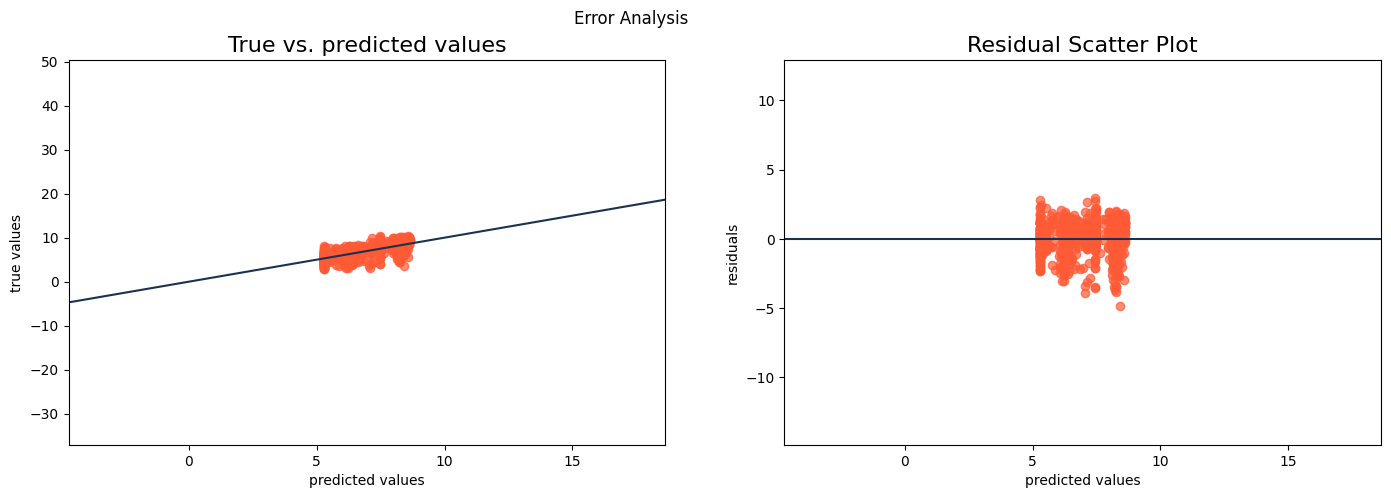

In [139]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10))
    
error_analysis(y_test, y_pred_test)

AttributeError: 'Pipeline' object has no attribute 'coef_'

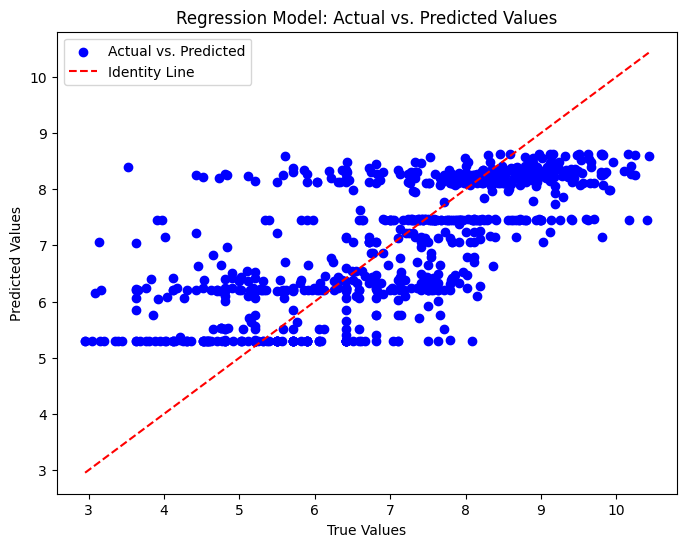

In [138]:

# Plotting the results
plt.figure(figsize=(8, 6))

# Scatter plot of true vs. predicted values
plt.scatter(y_test, y_pred_test, color='blue', label='Actual vs. Predicted')

# Plot the identity line (y = x)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Identity Line')

plt.title('Regression Model: Actual vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()